In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# import pmcpy as mcpy 
import numpy as np
import matplotlib.pyplot as plt
#from pmcpy import so3, Chain, RBP, Pivot, Crankshaft, Dumps, SingleTriad, ClusterTrans
import pmcpy.run.equilibrate as em # actually not equilibrate but energy minimization

# # # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
# %matplotlib ipympl

def plot(pos, triads,ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    for position, frame in zip(pos,triads):
        right, up, forward = frame[:,0], frame[:,1], frame[:,2]
        ax.quiver(*position, *right, length=0.2, color='g')
        ax.quiver(*position, *up, length=0.2, color='b')
        ax.quiver(*position, *forward, length=0.2, color='r')

    ax.plot(*pos.T, color='black', label='Control Points',lw=1)
    ax.axis('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

def plot_frames(spline,ax=None):
    pos, triads = get_pos_and_triads(spline)
    plot(pos, triads, ax=ax)
    
def make_sequence(n_bp):
    return ''.join(['ATCG'[np.random.randint(4)] for i in range(n_bp)])

def get_pos_and_triads(spline):
    # get origins of the base pair frames and the triads of the base pair frames (as column vectors for each frame)
    return spline.frames[:,0,:], spline.frames[:,1:,:].transpose((0, 2, 1))

def update_spline(spline, out):
    # update the spline with new positions and triads
    spline.frames[:,0,:] = out['positions'] # set the origins of the frames
    spline.frames[:,1:,:] = out['triads'].transpose((0, 2, 1))# set the triads of the frames as row vectors
    
def minimize_spline(spline, fixed=[], closed=False, sequence=None, endpoints_fixed=False):
    # get the positions and triads of the base pair frames
    pos, triads = get_pos_and_triads(spline)

    # start with temperature annealing at 100000K
    out  = em.equilibrate(triads,pos,sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=100000,num_cycles=100,exvol_rad=1)
    # then do a final equilibration at 300K
    out = em.equilibrate(out['triads'],out['positions'],sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=300,exvol_rad=1)

    # update the spline with the new positions and triads
    update_spline(spline, out)

    return out

In [3]:
from scipy.spatial.transform import Rotation as R

def find_minima(lst):
    """Finds the indices of local minima in a list."""
    return [i for i in range(1, len(lst) - 1) if lst[i - 1] > lst[i] and lst[i + 1] > lst[i]]

def compute_left_over(bp_range, min_bp, bp_per_turn, rotation_difference):
    """Computes the left-over rotational difference for a range of base pairs."""
    cumul_twist = np.arange(min_bp, min_bp + bp_range) * 360 / bp_per_turn
    return cumul_twist % 360 - rotation_difference

def compute_twist_diff_per_bp(optimal_bp, left_over, min_bp):
    """Calculates the twist difference per base pair for an optimal base pair number."""
    total_twist_diff = left_over[optimal_bp - min_bp]
    return total_twist_diff / optimal_bp

def check_within_tolerance(twist_diff_per_bp, tolerance):
    """Checks if the twist difference per base pair is within the specified tolerance."""
    return np.abs(twist_diff_per_bp) < tolerance

def plot_leftover(min_bp,left_over):
    # Plotting the left-over rotational differences
    plt.plot(np.arange(min_bp, min_bp + len(left_over)), np.abs(left_over))
    plt.xlabel('Number of Base Pairs')
    plt.ylabel('Absolute Left Over')
    plt.show()

def find_optimal_bps(positions, bp_per_turn, rise, bp_range, rotation_difference, tolerance, plot=False):
    """Finds optimal base pairs that satisfy the given tolerance.

    Args:
    positions: The positions of base pairs.
    bp_per_turn: Base pairs per turn.
    rise: Component of arc length.
    bp_range: Range of base pairs to consider.
    rotation_difference: The target rotation difference.
    tolerance: The tolerance for accepting an optimal base pair number.
    plot: If True, plots the left-over rotational differences.

    Returns:
    A list of dictionaries containing optimal base pair numbers and their twist differences per base pair.
    """
    min_arc = np.linalg.norm(positions[0] - positions[-1])
    min_bp = int(np.ceil(min_arc / rise))
    left_over = compute_left_over(bp_range, min_bp, bp_per_turn, rotation_difference)
    
    if plot:
        plot_leftover(min_bp,left_over)

    minima = find_minima(np.abs(left_over))
    results = []

    for min_val in minima:
        optimal_bp = min_bp + min_val
        twist_diff_per_bp = compute_twist_diff_per_bp(optimal_bp, left_over, min_bp)
        if check_within_tolerance(twist_diff_per_bp, tolerance):
            results.append({
                'optimal_bp': optimal_bp ,
                'twist_diff_per_bp': np.round(twist_diff_per_bp, 3)
            })
    if len(results) > 0:
        for result in results[:1]:
            print(f'Optimal BP: {result["optimal_bp"]}, Twist Difference per BP: {result["twist_diff_per_bp"]} degrees')
    else:
        print("No optimal number of base pairs found within the specified tolerance.")
    return results


def compute_euler_angles(frame_A, frame_B):
    # Compute the rotation matrix R that transforms frame A to frame B
    rotation_matrix = np.dot(frame_B.T, frame_A)
    
    # Create a rotation object from the rotation matrix
    rotation = R.from_matrix(rotation_matrix)
    
    # Convert the rotation to Euler angles (ZYX convention)
    euler_angles = rotation.as_euler('zyx', degrees=True)
    
    # Return the Euler angles: yaw (Z), pitch (Y), and roll (X)
    return euler_angles

def get_twist_difference(frame_a, frame_b):
    """Calculates the twist difference between two frames."""
    
    b1 = frame_a[1:]/np.linalg.norm(frame_a[1:])
    b2 = frame_b[1:]/np.linalg.norm(frame_b[1:])

    euler_angles = compute_euler_angles(b1, b2)
    return euler_angles[-1]

(-23.5, 26.0, -2.25, 47.25, -18.5625, 18.5625)

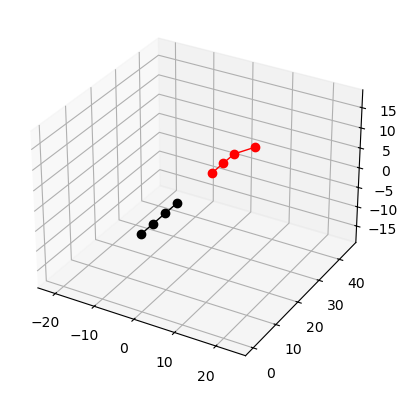

In [28]:
control_points_A = np.array([[0,0,-1],[0,1,0],[0,2,0],[0,3,0]])*5
control_points_B = np.array([[5,3,5],[5,3,6],[5,3,7],[5,4,8]])*5

control_points_A = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*5
control_points_B = np.array([[0,6,0],[0,7,0],[0,8,0],[0.5,9,0]])*5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points_A.T,'-o', color='black', label='Control Points A',lw=1)
ax.plot(*control_points_B.T,'-o', color='red', label='Control Points B',lw=1)
ax.axis('equal')

In [29]:
spline_A = mdna.SplineFrames(control_points_A)
spline_B = mdna.SplineFrames(control_points_B)

dna_a = mdna.StructureGenerator(spline_A)
dna_b = mdna.StructureGenerator(spline_B)

ATCCCAATGAGAAATTGGGATGAGCTGCCCACAAATGTTCTTAGG
TGCAGCCACAAGTTGCTCGTCAGAGACCCTTGTAAACACGTGTCTTG


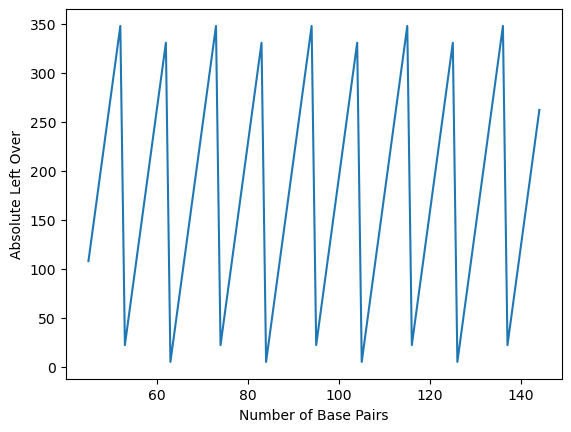

Optimal BP: 53, Twist Difference per BP: 0.422 degrees
[{'optimal_bp': 53, 'twist_diff_per_bp': 0.422}, {'optimal_bp': 63, 'twist_diff_per_bp': 0.083}, {'optimal_bp': 74, 'twist_diff_per_bp': 0.302}, {'optimal_bp': 84, 'twist_diff_per_bp': 0.062}, {'optimal_bp': 95, 'twist_diff_per_bp': 0.235}]


In [30]:
start = spline_A.frames[-1]
end = spline_B.frames[0]

rotation_difference = get_twist_difference(start, end)

bp_per_turn = 10.5
rise = 0.34
bp_range = 100
tolerance = np.abs((360 / 10.4) - (360 / 10.6))

optimal_bps = find_optimal_bps(np.array([start[0], end[0]]), bp_per_turn, rise, bp_range, rotation_difference, tolerance, plot=True)
print(optimal_bps[:5])

53


(-23.5, 26.0, -2.25, 47.25, -18.5625, 18.5625)

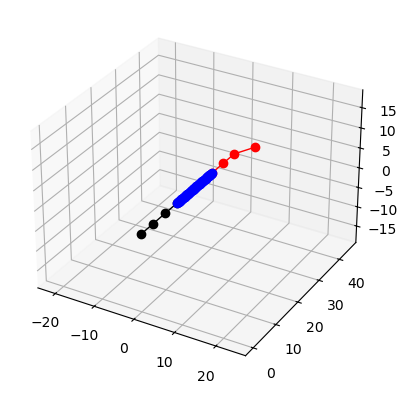

In [32]:
def interplotate_points(start, end, n):
    return np.array([start + (end-start)*i/n for i in range(n+1)])
number_of_bp = optimal_bps[0]['optimal_bp']
print(number_of_bp)


number_of_bp = number_of_bp
control_points_C = interplotate_points(start[0], end[0], number_of_bp)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points_A.T,'-o', color='black', label='Control Points A',lw=1)
ax.plot(*control_points_B.T,'-o', color='red', label='Control Points B',lw=1)
ax.plot(*control_points_C.T,'-o', color='blue', label='Control Points C',lw=1)
ax.axis('equal')

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

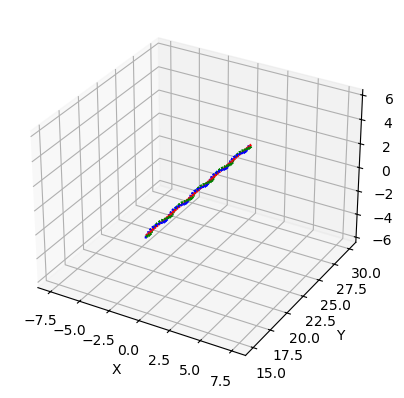

In [33]:

distance = np.linalg.norm(start-end)
spline_C = mdna.SplineFrames(control_points_C,frame_spacing=distance/len(control_points_C))
spline_C.plot_frames(equal=True)

In [34]:
# combine splines A B and C and remember the fixed nodes/frames of A and B

spline_C.frames = np.concatenate([spline_A.frames[:-1],spline_C.frames,spline_B.frames[1:]])

In [35]:
spline_C.frames.shape,spline_A.frames.shape, spline_B.frames.shape
# fix first and last 45 indices of total length of 257 frames
margin = 10
fixed = list(range(spline_A.frames.shape[0]-margin))+list(range(spline_C.frames.shape[0]-spline_B.frames.shape[0]+margin,spline_C.frames.shape[0]))

In [36]:
sequence = make_sequence(spline_C.frames.shape[0])
sequence

'GGGCTGGACCTGCGCCTTGGTGGTAGAAGTAGCGAGAGTGTTCTTGAAAATTCGAGTGAAACCGTTGATTACACGGTCAGTTTCCACCTCAGGTGTTAAATACTAACTCCAGCAGGCGTGCTCCGTTTATGGTCCAAACCTATAC'

In [37]:
out = minimize_spline(spline_C, sequence=sequence, closed=False, endpoints_fixed=False, fixed=fixed)

cycle 0: 
18 moves initated
E = 955.0881306675361 kT
E = 336.2749321843798 kT
E = 321.88400490114066 kT
E = 313.5390238485902 kT
E = 310.1085952630139 kT
E = 308.0257217458449 kT
E = 303.5672576269789 kT
E = 301.28525559167224 kT
E = 298.8521655867927 kT
E = 298.0831455818057 kT
E = 292.5416091527554 kT
E = 293.274701220542 kT
18 moves initated


In [38]:
import mdtraj as md
import nglview as nv

xyz = np.array(out['confs'])
print(xyz.shape)

topology = md.Topology()
chain = topology.add_chain()
for i in range(xyz.shape[1]):
    residue = topology.add_residue(name='Ar', chain=chain)
    atom = topology.add_atom('Ar',element=md.element.argon, residue=residue)

bonds = np.array([[i,i+1] for i in range(xyz.shape[1]-1)])
for bond in bonds:
    topology.add_bond(topology.atom(bond[0]),topology.atom(bond[1]))

test = md.Trajectory(xyz,topology=topology)

view = nv.show_mdtraj(test[::5])
view.clear()
view.add_representation('ball+stick',radius=1)
view

(251, 145, 3)


NGLWidget(max_frame=50)

In [39]:

dna_c = mdna.StructureGenerator(spline_C)
traj = dna_c.get_traj()
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('licorice', selection='all')
view

CAGGATTCCACGTAAGTCAAACTACGCAGATTCAACATGTTTACTTATTAGCCTTCCACATGATATCTTCACGGGAGCCGCGATAGATGCTAGAGCGCAGGTCCAGCTGCACGGACAACAGTCCAAAGCCTTGCGCATCGCATCT


NGLWidget()

In [40]:
traj.save('final.pdb')